In [39]:
#import libraries
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import statsmodels.stats.api as sms
import statistics
from statistics import median
from datetime import datetime

**About the dataset**

An imaginary customer wanted to test which gives better performance, X or Y
(another FMP).

● To make the test fair and valid, it was run as an ad study.

● Ad Study is a randomized controlled trial: Facebook splits the audience in half and makes sure
users see ads from X or Y, but never both.

● Ad Study was run from 2017-11-14T12:30 to 2017-11-30T13:30 with 50/50 split.

● Attribution: 28 day click, no view through

● Note: values in the "spent" column are cents

**The Task**

Analyze which FMP (Facebook Marketing Partners) - X or Y - gave better results in terms of CPA (Cost per action): X or Y and why?

● Create relevant plot(s) to support your claim on which FMP performed better - which metric(s)
did you choose to visualize and why?

● Evaluate the statistical significance of your findings

In [40]:
#import dataset
data_original = pd.read_csv('Data.csv')
data_original

,cell,adgroup_id,date,spent,impressions,clicks,conversions
0,x,5a0ad96be6b83b6df54da177,14/11/2017,2583,1026,19,6
1,x,5a0ad96be6b83b6df54da177,15/11/2017,1819,744,14,1
2,x,5a0ad96be6b83b6df54da177,21/11/2017,555,272,1,0
3,x,5a0ad96be6b83b6df54da179,14/11/2017,2793,1063,13,4
4,x,5a0ad96be6b83b6df54da179,15/11/2017,1714,702,5,3
...,...,...,...,...,...,...,...
317,y,5a12e38ec7e28c3c3e175ad4,24/11/2017,23169,11737,244,81
318,y,5a12e38ec7e28c3c3e175ad4,25/11/2017,18552,9843,227,86
319,y,5a12e38ec7e28c3c3e175ad4,26/11/2017,20021,12220,313,89
320,y,5a12e38ec7e28c3c3e175ad4,27/11/2017,19155,11637,287,73


### A bit of knowledge - FB for business:

**Impressions**: The number of times that an ad was served, on-screen, or viewable based on data received from an ad platform. The type of impression that is reported depends on how each platform counts impressions, and may not be the same for all platforms. Impressions for Facebook and Facebook-owned platforms are reported automatically, and are counted as the number of times that your ads were on screen.


**Clicks**: The number of times that an ad was clicked based on data received from an ad platform. Note: Clicks for Facebook and Facebook-owned platforms are reported automatically.

**Conversions**: The number of times that a specific action such as a purchase or add to cart was taken. Conversions for your reports can be chosen from any available event or custom conversion that you've set up for your pixel or app.

Source: https://www.facebook.com/business/help/930427367063128?id=399393560487908 

In [41]:
#check overall data 
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cell         322 non-null    object
 1   adgroup_id   322 non-null    object
 2   date         322 non-null    object
 3   spent        322 non-null    int64 
 4   impressions  322 non-null    int64 
 5   clicks       322 non-null    int64 
 6   conversions  322 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 17.7+ KB


In [42]:
data_original['date'] = pd.to_datetime(data_original['date'])

### KPIs:

Revenue:
- Click conversion Rate = (number of conversions/number of clicks -1)*100

- Conversions per 1000 impressions = (number of conversions/number of impressions -1)*1000

- Impression to Click Rate = (number of clicks/number of impressions -1)*100

Costs:

- Cost per conversion = sprent/#conversions (cents)
- Cost per click = sprent/#clicks (cents)


In [43]:
data_original['Click Conversion Rate'] = data_original['conversions']/data_original['clicks']*100
data_original['Conversions per 1000 impressions'] = data_original['conversions']/data_original['impressions']*1000
data_original['Impression to Click Rate'] = data_original['clicks']/data_original['impressions']*100

data_original['Cost per conversion'] = data_original['spent']/data_original['conversions']
data_original['Cost per click'] = data_original['spent']/data_original['clicks']


In [44]:
data_original.replace([np.inf, -np.inf], np.nan,inplace=True)

In [45]:
#let's see how the data is distributed
data_original.describe()

,spent,impressions,clicks,conversions,Click Conversion Rate,Conversions per 1000 impressions,Impression to Click Rate,Cost per conversion,Cost per click
count,322.000000,322.000000,322.000000,322.000000,288.000000,322.000000,322.000000,263.000000,288.000000
mean,3741.695652,1876.385093,40.704969,14.897516,47.614790,6.841006,1.595434,402.987621,196.509250
std,7729.202721,3979.247483,93.098028,33.359629,44.255560,6.303727,1.111651,336.656839,192.621331
min,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.200000,25.338983
25%,812.000000,321.750000,3.000000,1.000000,25.000000,2.833531,0.777282,198.173077,80.546875
50%,1749.500000,809.500000,11.000000,5.000000,38.649133,6.006372,1.457654,293.300000,136.223684
75%,3026.750000,1405.000000,32.000000,13.000000,57.142857,8.950186,2.355044,502.558333,232.135417
max,50934.000000,29493.000000,687.000000,257.000000,450.000000,42.424242,5.678233,2562.000000,1293.000000


In [46]:
#check null values - no null values 
data_original.isnull().sum()

#when 0 click and/or 0 conversions
#we will treat the null values depending on the KPI analysed (example: no need to do anything when analysing Conversions per 1000 impressions)
#we don't want to lose meaningfulness


cell                                 0
adgroup_id                           0
date                                 0
spent                                0
impressions                          0
clicks                               0
conversions                          0
Click Conversion Rate               34
Conversions per 1000 impressions     0
Impression to Click Rate             0
Cost per conversion                 59
Cost per click                      34
dtype: int64

### Click Conversion Rate

Click conversion rate lets us see which ad generates the most conversions after someone clicks an ad. 

In [47]:
kpi = 'Click Conversion Rate'

Text(0.5, 1.0, 'Click Conversion Rate')

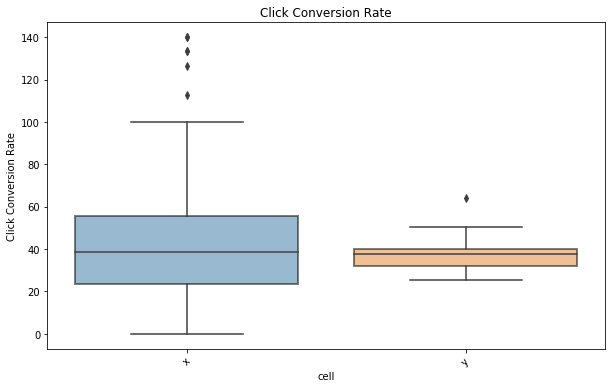

In [48]:
plt.figure(figsize = (10, 6))

#remove outliers to visualize
ax = sns.boxplot(x='cell', y=kpi, data = data_original[data_original[kpi]<150])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Click Conversion Rate')

In [49]:
#preprare for time series data:
data_x = data_original[data_original['cell']=='x'].groupby(['date']).mean()
data_y = data_original[data_original['cell']=='y'].groupby(['date']).mean()

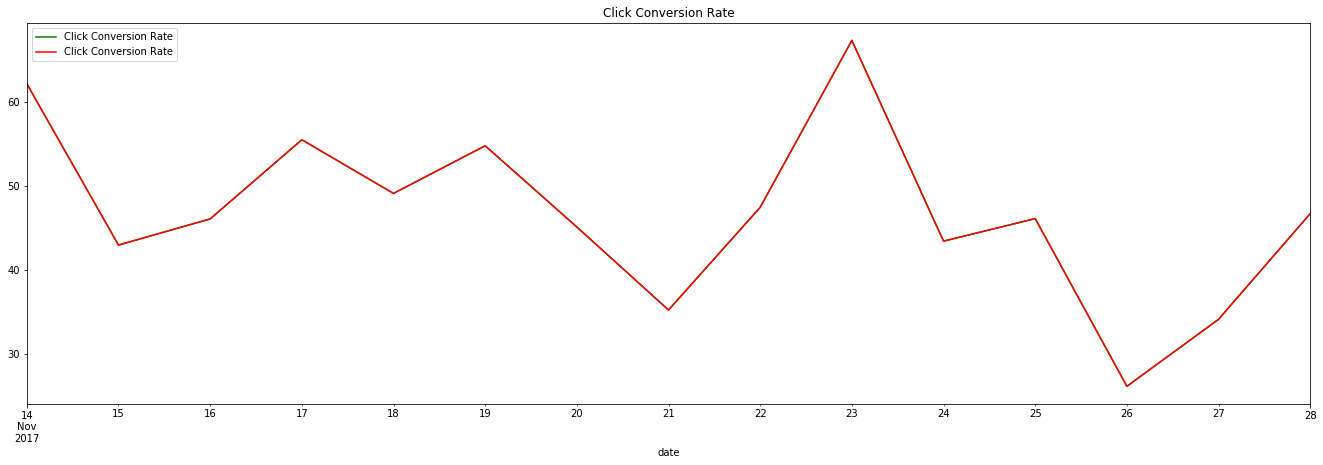

In [50]:
data_x[kpi].plot(figsize=(23, 7), title='Click Conversion Rate', color='green')
data_x[kpi].plot(figsize=(23, 7), color='red')

plt.legend(loc="upper left")

In [51]:
click_conversion = data_original.groupby('cell')[kpi]

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

click_conversion = click_conversion.agg([np.mean, std_p, se_p])
click_conversion.columns = ['conversions per 1000 impressions', 'std_deviation', 'std_error']
click_conversion.style.format('{:.3f}')


,conversions per 1000 impressions,std_deviation,std_error
cell,,,
x,48.512,45.877,nan
y,37.275,8.560,1.785


In [52]:
#drop NaN in this kpi
control_results = data_original[data_original['cell'] == 'x'][kpi].dropna()
treatment_results = data_original[data_original['cell'] == 'y'][kpi].dropna()

results = stats.ttest_ind(control_results,treatment_results)
print(results)

Ttest_indResult(statistic=1.168865643441803, pvalue=0.24343108376622621)


**Since our p-value=0.24 is above the α=0.05 threshold, we can not reject the Null hypothesis Hₒ, which means that x did not perform significantly different (better in this case) than y**

### Conversions per 1000 impressions
Conversions per 1,000 impressions lets you see how efficiently your ads generate conversions from impressions. 

In [53]:
kpi = 'Conversions per 1000 impressions'

Text(0.5, 1.0, 'Conversion Rate')

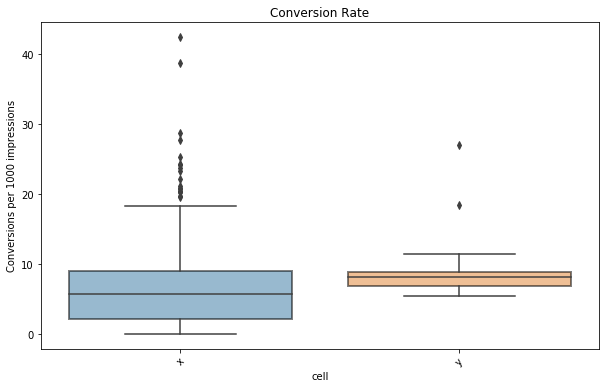

In [54]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='cell', y=kpi, data = data_original)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Conversion Rate')

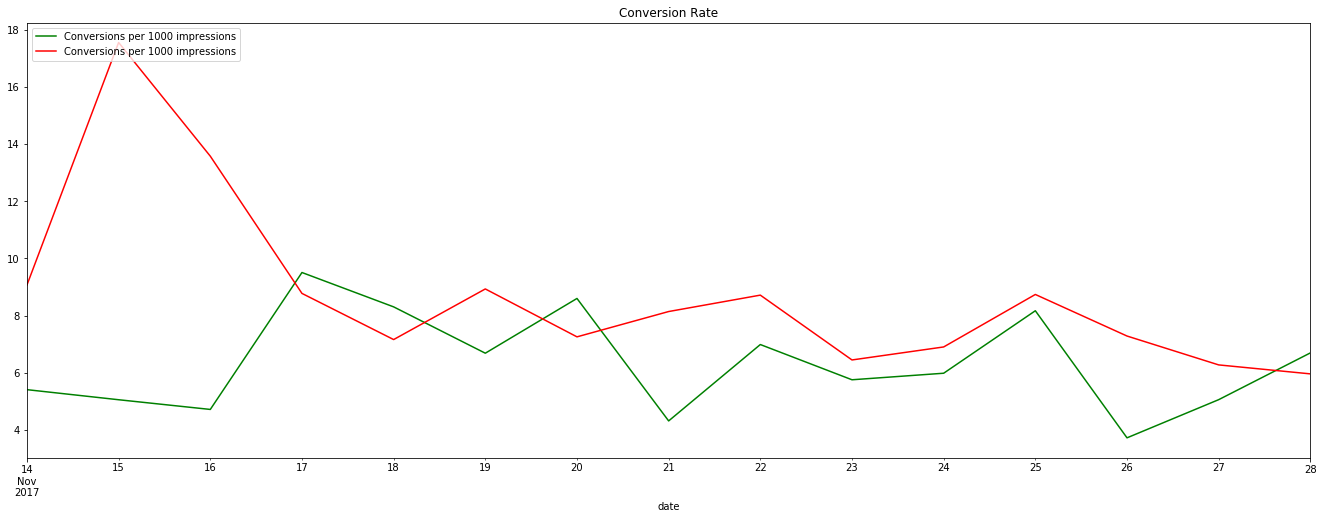

In [55]:
data_x[kpi].plot(figsize=(23, 8), title='Conversion Rate', color='green')
data_y[kpi].plot(figsize=(23, 8), color='red')

plt.legend(loc="upper left")

In [56]:
conversion_1000_impressions = data_original.groupby('cell')[kpi]

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_1000_impressions = conversion_1000_impressions.agg([np.mean, std_p, se_p])
conversion_1000_impressions.columns = ['conversions per 1000 impressions', 'std_deviation', 'std_error']
conversion_1000_impressions.style.format('{:.3f}')


,conversions per 1000 impressions,std_deviation,std_error
cell,,,
x,6.667,6.373,0.369
y,9.105,4.597,0.959


In [57]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = data_original[data_original['cell'] == 'x'][kpi].dropna()
treatment_results = data_original[data_original['cell'] == 'y'][kpi]

results = stats.ttest_ind(control_results,treatment_results)
print(results)

Ttest_indResult(statistic=-1.7932344369440092, pvalue=0.07387964900184918)


**Since our p-value=0.07 is slightly above the α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that Y performed significantly different (better in this case) than X. However, this result is significant at 10% p-value**

### Cost per Conversion
Cost per conversion shows how much it was spent to generate a conversion or acquire a customer. Ideally, your cost per conversion goal should not exceed the conversion value, but in this case we don't have data on the revenue generated by each conversion.

In [58]:
kpi = 'Cost per conversion'

In [59]:
#deal with null values in cost per conversion
#replace with zero

data_original[kpi] = data_original[kpi].replace(np.nan, 0)

In [60]:
data_original.columns

Index(['cell', 'adgroup_id', 'date', 'spent', 'impressions', 'clicks',
       'conversions', 'Click Conversion Rate',
       'Conversions per 1000 impressions', 'Impression to Click Rate',
       'Cost per conversion', 'Cost per click'],
      dtype='object')

Text(0.5, 1.0, 'Spent per Conversion')

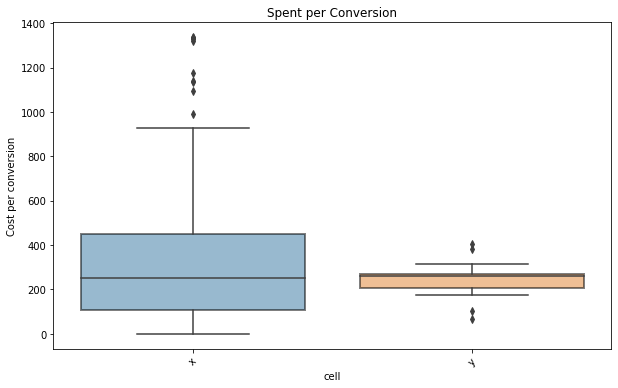

In [61]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='cell', y=kpi, data = data_original[data_original[kpi]<1500])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Spent per Conversion')

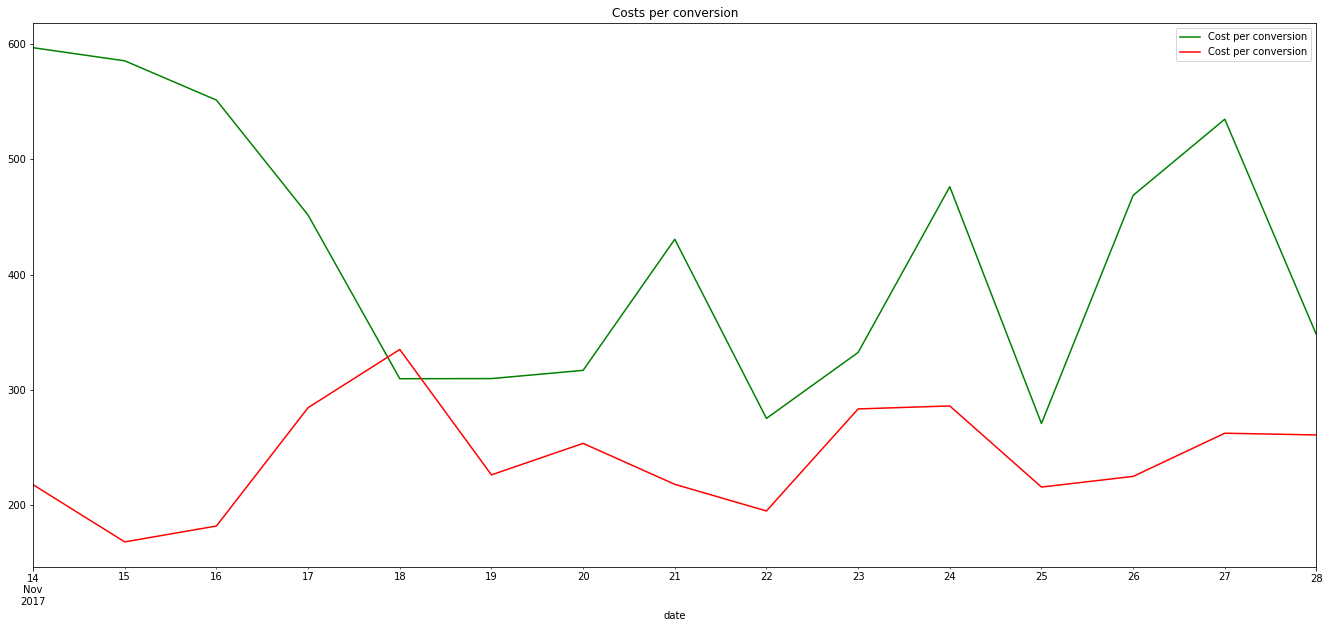

In [62]:
data_x[kpi].plot(figsize=(23, 10), title='Costs per conversion', color='green')
data_y[kpi].plot(figsize=(23, 10), color='red')

plt.legend(loc="upper right")


In [63]:
spent_conversion = data_original.groupby('cell')[kpi]

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

spent_conversion = spent_conversion.agg([np.mean, std_p, se_p])
spent_conversion.columns = ['conversion_rate', 'std_deviation', 'std_error']
spent_conversion.replace([np.inf, -np.inf], 0,inplace=True)

spent_conversion

,conversion_rate,std_deviation,std_error
cell,,,
x,335.955536,352.722900,20.398492
y,240.653867,74.260059,15.484293


In [64]:
control_results = data_original[data_original['cell'] == 'x'][kpi]
treatment_results = data_original[data_original['cell'] == 'y'][kpi]

results = stats.ttest_ind(control_results,treatment_results)
print(results)

Ttest_indResult(statistic=1.2895515362451733, pvalue=0.19813766646816455)


**Since our p-value=0.19 is above the α=0.05 threshold, we fail to reject the Null hypothesis Hₒ, which means that Y did not perform significantly different (lower cost per conversion in this case) than X**

### Cost per click

Cost per click shows how much it was spent to generate a click from a user. 

In [65]:
kpi = 'Cost per click'

In [66]:
#deal with null values in cost per conversion
#replace with zero

data_original[kpi] = data_original[kpi].replace(np.nan, 0)

Text(0.5, 1.0, 'Spent per Click')

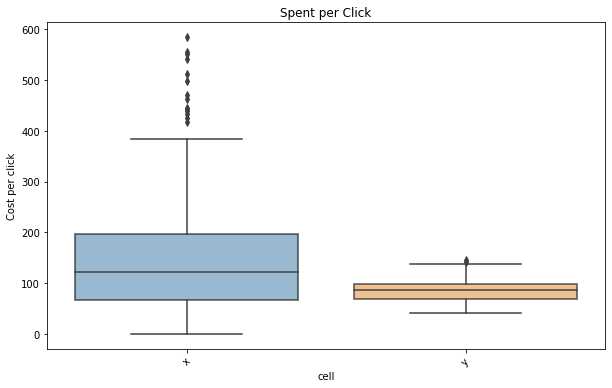

In [67]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='cell', y=kpi, data = data_original[data_original[kpi]<600])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)
plt.title('Spent per Click')

In [68]:
spent_click = data_original.groupby('cell')[kpi]

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

spent_click = spent_click.agg([np.mean, std_p, se_p])
spent_click.columns = ['conversion_rate', 'std_deviation', 'std_error']
spent_click

,conversion_rate,std_deviation,std_error
cell,,,
x,182.616922,197.040887,11.395169
y,86.617581,27.448117,5.723328


In [69]:
control_results = data_original[data_original['cell'] == 'x'][kpi]
treatment_results = data_original[data_original['cell'] == 'y'][kpi]

results = stats.ttest_ind(control_results,treatment_results)
print(results)

Ttest_indResult(statistic=2.327549766682943, pvalue=0.020559338313897182)


**Since our p-value=0.02 is below the α=0.05 threshold, we reject the Null hypothesis Hₒ, which means that Y does hold significantly different costs (lower click costs) than X.**

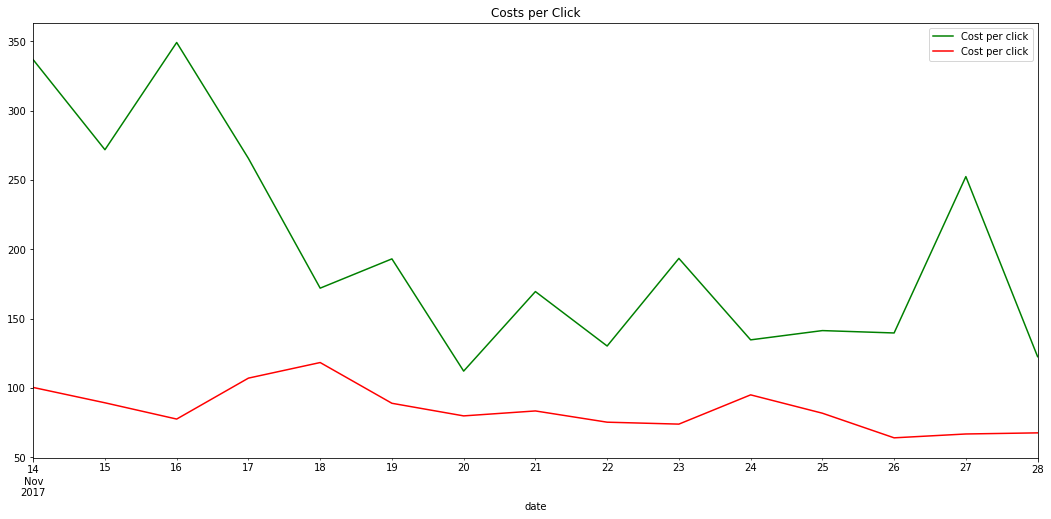

In [70]:
data_x[kpi].plot(figsize=(18, 8), title='Costs per Click', color='green')
data_y[kpi].plot(figsize=(18, 8), color='red')

plt.legend(loc="upper right")

### Answers/Conclusions

The best KPI to analyze Customer Profitability in this case would be Spent per conversion. Since we do not have data on the revenue generated by each click nor each conversion, we can not calculate profit. Therefore I decided to use conversions as a proxy for revenue generated. 

**a)** The FMP that showed better CPA results is Y. According to the box plots and statistic tests above, X performs better when it comes to conversion clicks and less costs per click. 

**b)** The time series plots above show the KPIs' evolution throughout the 2 weeks window. When it comes to Conversion Rate, we see that X started with a higher conversion rate (impressions to conversions) but stabilized around 0.7%. However, the results are not statistically significant.
Moreover, when it comes to conversions per 1000 impressions the rate, the KPI that allows us to check how efficient a FMP is in turning the viewed ads into conversions, X performs better than its peer,with an average of 9.1 vs 6.7 conversions over 1000 impressions, significant at a 10% level. 
These 2 KPIs show that costumers using X are, on average, more likely to click the ad that they saw on their screen and that click turned into a conversion.
When it comes to evaluate profitability one must also look at the costs associated with the strategy. Results show that ads from Y are incurring in higher costs per click (1.8€ vs 0.9€, on average), significant at 5%, across the period of time. I chose to visualise data in box plots and time series on these specific KPIs so that I could look deeper into how the metrics are displayed across observations and time frame and evaluate how effective each FMP was in turning impressions into clicks and into conversions, while also looking into the resources (money in this case) used to reach those goals.


**c)** Overall, I looked into how the 2 groups performed and then check if the difference between this peformance was significant. I evaluated the statistical significance of the result by  testing the hypothesis (e.g. Hₒ-> X performance = Y performance). Since we have a small sample (namely when it comes to Y group, with 23 observations), I used t-test package in the stats python module to compare the control and the treatment group. Finally, I concluded comparing the p-value with the alpha (5% or 10%), in case the p-value generated is smaller than the significance level we set, it is more likely that the groups are different in terms of the KPI we are analyzing. 